In [1]:
# Imports
import os
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.io import wavfile
from scipy import signal, fftpack
from testing_functions import test_hss
from process_functions import preprocessing_audio
from utils import find_and_open_audio, signal_segmentation, get_resp_segments
from heart_sound_segmentation.filter_and_sampling import downsampling_signal, \
    upsampling_signal
from respiratory_sound_classification.respiratory_sound_management import get_label_filename_ML
from source_separation.descriptor_functions import get_spectrogram
from IPython.display import Audio
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing, linear_model, svm
from pybalu.feature_selection import sfs

# Definición coeficientes cepstrales

In [2]:
# Funciones de características
def get_filterbanks(N, samplerate, freq_lim, n_coefs,
                    scale_type='mel', filter_type='triangular',
                    norm_filters=True, plot_filterbank=False):
    '''
    
    Parameters
    ----------
    N : ndarray
        Largo de la señal.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''
    def _freq_to_bin(f):
        # Definición del bin correspondiente en la definición
        # del intervalo de cálculo. Se usa (N - 1) ya que los bins
        # se definen entre 0 y (N - 1) (largo N)
        return np.rint(f / samplerate * (N - 1)).astype(int)
    
    
    def _triangular_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i] + 1] = \
                np.linspace(0, 1, abs(bins_points[i] - bins_points[i - 1] + 1))
            
            # Tramo descendente del filtro triangular
            filter_bank[i - 1][bins_points[i]:bins_points[i + 1] + 1] = \
                np.linspace(1, 0, abs(bins_points[i + 1] - bins_points[i] + 1))
            
        return filter_bank
    
    
    def _hanning_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = \
                np.hanning(abs(bins_points[i + 1] - bins_points[i - 1] + 1))
        
        return filter_bank
    
    
    def _squared_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = 1
        
        return filter_bank
    
    
    def _norm_filterbank(filter_bank):
        # Definición del banco de filtros de salida
        filter_bank_out = np.zeros((n_coefs, N))
        
        # Normalizar los filtros a energía 1
        for i in range(n_coefs):
            filter_bank_out[i] = filter_bank[i] / \
                                 sum(filter_bank[i] ** 2)
            
        return filter_bank_out
    
    
    # Definición de los bines en base a las frecuencias de cada filtro
    if scale_type == 'linear':
        # Definición de las "n_coefs" frecuencias equiespaciadas entre
        # 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya que se 
        # necesitan para definir los límites de los filtros.
        freqs = np.arange(0, (n_coefs + 1) + 1) * freq_lim / (n_coefs + 1)
    
    
    elif scale_type == 'mel':
        # Definición del límite en frecuencias de mel (para no pasarse del
        # freq_lim al devolverse)
        mel_freq_lim = 2595 * np.log10(1 + freq_lim / 700)
        
        # Definición de las "n_coefs" frecuencias espaciadas en escala mel 
        # entre 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya 
        # que se necesitan para definir los límites de los filtros.
        mel_freqs = np.arange(0, (n_coefs + 1) + 1) * mel_freq_lim / (n_coefs + 1)
        
        # Transformando de intervalos equi espaciados usando la escala
        # de mel. Es necesario hacer la transformación inversa ya que
        # en este caso se dice que lo equi espaciado viene de mel
        freqs = 700 * (10 ** (mel_freqs / 2595) - 1)
    
    else:
        raise Exception('Opción de tipo de coeficiente cepstral no válido.')
    
    
    # Transformando a bins
    bins_to = _freq_to_bin(freqs)
    
    
    # Obtención del banco de filtros
    if filter_type == 'triangular':
        filter_bank = _triangular_filter(bins_to)
        
    if filter_type == 'hanning':
        filter_bank = _hanning_filter(bins_to)
    
    elif filter_type == 'squared':
        filter_bank = _squared_filter(bins_to)
    
    # Normalizar por la energía de la señal
    if norm_filters:
        filter_bank = _norm_filterbank(filter_bank)
    
    
    # Gráfico del banco de filtros
    if plot_filterbank:
        plt.figure()
        
        # Definición del vector de frecuencias
        f_plot = np.arange(N) * samplerate / N
        
        for i in range(n_coefs):
            plt.plot(filter_bank[i])
            # plt.plot(f_plot, filter_bank[i])

        for i in bins_to:
            # plt.axvline(i * samplerate / N, c='silver', linestyle=':')
            plt.axvline(i, c='silver', linestyle=':')
            
        # plt.xlim([0, freq_lim])
        plt.xlim([0, bins_to[-1]])
        plt.show()
    
    
    return filter_bank


def get_filterbanks_plots(N, samplerate, freq_lim, n_coefs,
                          scale_type='mel', filter_type='triangular',
                          norm_filters=True, plot_filterbank=False):
    '''
    
    Parameters
    ----------
    N : ndarray
        Largo de la señal.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''
    def _freq_to_bin(f):
        # Definición del bin correspondiente en la definición
        # del intervalo de cálculo. Se usa (N - 1) ya que los bins
        # se definen entre 0 y (N - 1) (largo N)
        return np.rint(f / samplerate * (N - 1)).astype(int)
    
    
    def _triangular_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i] + 1] = \
                np.linspace(0, 1, abs(bins_points[i] - bins_points[i - 1] + 1))
            
            # Tramo descendente del filtro triangular
            filter_bank[i - 1][bins_points[i]:bins_points[i + 1] + 1] = \
                np.linspace(1, 0, abs(bins_points[i + 1] - bins_points[i] + 1))
            
        return filter_bank
    
    
    def _hanning_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = \
                np.hanning(abs(bins_points[i + 1] - bins_points[i - 1] + 1))
        
        return filter_bank
    
    
    def _squared_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = 1
        
        return filter_bank
    
    
    def _norm_filterbank(filter_bank):
        # Definición del banco de filtros de salida
        filter_bank_out = np.zeros((n_coefs, N))
        
        # Normalizar los filtros a energía 1
        for i in range(n_coefs):
            filter_bank_out[i] = filter_bank[i] / \
                                 sum(filter_bank[i] ** 2)
            
        return filter_bank_out
    
    
    # Definición de los bines en base a las frecuencias de cada filtro
    if scale_type == 'linear':
        # Definición de las "n_coefs" frecuencias equiespaciadas entre
        # 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya que se 
        # necesitan para definir los límites de los filtros.
        freqs = np.arange(0, (n_coefs + 1) + 1) * freq_lim / (n_coefs + 1)
    
    
    elif scale_type == 'mel':
        # Definición del límite en frecuencias de mel (para no pasarse del
        # freq_lim al devolverse)
        mel_freq_lim = 2595 * np.log10(1 + freq_lim / 700)
        
        # Definición de las "n_coefs" frecuencias espaciadas en escala mel 
        # entre 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya 
        # que se necesitan para definir los límites de los filtros.
        mel_freqs = np.arange(0, (n_coefs + 1) + 1) * mel_freq_lim / (n_coefs + 1)
        
        # Transformando de intervalos equi espaciados usando la escala
        # de mel. Es necesario hacer la transformación inversa ya que
        # en este caso se dice que lo equi espaciado viene de mel
        freqs = 700 * (10 ** (mel_freqs / 2595) - 1)
    
    else:
        raise Exception('Opción de tipo de coeficiente cepstral no válido.')
    
    
    # Transformando a bins
    bins_to = _freq_to_bin(freqs)
    
    
    # Obtención del banco de filtros
    if filter_type == 'triangular':
        filter_bank = _triangular_filter(bins_to)
        
    if filter_type == 'hanning':
        filter_bank = _hanning_filter(bins_to)
    
    elif filter_type == 'squared':
        filter_bank = _squared_filter(bins_to)
    
    # Normalizar por la energía de la señal
    if norm_filters:
        filter_bank = _norm_filterbank(filter_bank)
    
    
    # Gráfico del banco de filtros
    if plot_filterbank:
        plt.figure()
        
        # Definición del vector de frecuencias
        f_plot = np.arange(N) * samplerate / N
        
        for i in range(n_coefs):
            plt.plot(filter_bank[i])
            # plt.plot(f_plot, filter_bank[i])

        for i in bins_to:
            # plt.axvline(i * samplerate / N, c='silver', linestyle=':')
            plt.axvline(i, c='silver', linestyle=':')
            
        # plt.xlim([0, freq_lim])
        plt.xlim([0, bins_to[-1]])
        plt.show()
    
    
    return bins_to, filter_bank


def get_cepstral_coefficients_segment(signal_in, samplerate, freq_lim, n_coefs,
                                      scale_type='mel', filter_type='triangular',
                                      inverse_func='dct', norm_filters=True,
                                      plot_filterbank=False, power=2):
    '''
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''    
    # Definición de la cantidad de puntos a considerar
    filter_bank = get_filterbanks(len(signal_in), samplerate, freq_lim=freq_lim, 
                                  n_coefs=n_coefs, scale_type=scale_type, 
                                  filter_type=filter_type,
                                  norm_filters=norm_filters, 
                                  plot_filterbank=plot_filterbank)
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(np.fft.fft(signal_in)) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    filters_applied = filter_bank * energy_spectrum
    
    
    # Calculando el logaritmo de la energía de cada uno
    energy_coefs = np.log(filters_applied.sum(axis=1))
    
    # Calculando los coeficientes cepstrales
    if inverse_func == 'dct':
        cepstral_coefs = fftpack.dct(energy_coefs, norm='ortho')
    elif inverse_func == 'idft':
        cepstral_coefs = np.fft.ifft(energy_coefs).real
    else:
        raise Exception('Opción de tipo de función inversa no válida.')
    
    
    return cepstral_coefs


def get_cepstral_coefficients(signal_in, samplerate, spectrogram_params,
                              freq_lim, n_coefs, scale_type='mel', 
                              filter_type='triangular', inverse_func='dct', 
                              norm_filters=True, plot_filterbank=False, 
                              power=2):
    '''
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''    
    # Definición de la cantidad de puntos a considerar
    filter_bank = get_filterbanks(spectrogram_params['N'], samplerate, 
                                  freq_lim=freq_lim, 
                                  n_coefs=n_coefs, scale_type=scale_type, 
                                  filter_type=filter_type,
                                  norm_filters=norm_filters, 
                                  plot_filterbank=plot_filterbank)
    
    # Obtener el espectrograma de la señal
    t, f, S = get_spectrogram(signal_in, samplerate, N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=False)
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(S) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    energy_coefs = np.dot(filter_bank[:,:spectrogram_params['N']//2 + 1], 
                          energy_spectrum)
    
    # Aplicando el logaritmo
    energy_coefs = np.log(energy_coefs + 1e-10)
    
    # Calculando los coeficientes cepstrales
    if inverse_func == 'dct':
        cepstral_coefs = fftpack.dct(energy_coefs, norm='ortho', axis=0)
    elif inverse_func == 'idft':
        cepstral_coefs = np.fft.ifft(energy_coefs, axis=-1).real
    else:
        raise Exception('Opción de tipo de función inversa no válida.')
    
    
    return cepstral_coefs


def get_bands_coefficients(signal_in, samplerate, spectrogram_params,
                           freq_lim, n_coefs, scale_type='mel', 
                           filter_type='triangular', norm_filters=True, 
                           plot_filterbank=False, 
                           power=2):
    '''
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''    
    # Definición de la cantidad de puntos a considerar
    filter_bank = get_filterbanks(spectrogram_params['N'], samplerate, 
                                  freq_lim=freq_lim, 
                                  n_coefs=n_coefs, scale_type=scale_type, 
                                  filter_type=filter_type,
                                  norm_filters=norm_filters, 
                                  plot_filterbank=plot_filterbank)
    
    # Obtener el espectrograma de la señal
    t, f, S = get_spectrogram(signal_in, samplerate, N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=True)
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(S) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    energy_coefs = np.dot(filter_bank, energy_spectrum)
    
    return energy_coefs


def get_cepstral_coefficients_end2end(signal_in, samplerate, freq_lim, n_coefs,
                              scale_type='mel', filter_type='triangular',
                              inverse_func='dct', norm_filters=True,
                              plot_filterbank=False, power=2):
    '''
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''
    def _freq_to_bin(f):
        # Definición del bin correspondiente en la definición
        # del intervalo de cálculo. Se usa (N - 1) ya que los bins
        # se definen entre 0 y (N - 1) (largo N)
        return np.rint(f / samplerate * (N - 1)).astype(int)
    
    
    def _triangular_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i] + 1] = \
                np.linspace(0, 1, abs(bins_points[i] - bins_points[i - 1] + 1))
            
            # Tramo descendente del filtro triangular
            filter_bank[i - 1][bins_points[i]:bins_points[i + 1] + 1] = \
                np.linspace(1, 0, abs(bins_points[i + 1] - bins_points[i] + 1))
            
        return filter_bank
    
    
    def _hanning_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = \
                np.hanning(abs(bins_points[i + 1] - bins_points[i - 1] + 1))
        
        return filter_bank
    
    
    def _squared_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_coefs, N))
        
        for i in range(1, n_coefs + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = 1
        
        return filter_bank
    
    
    def _norm_filterbank(filter_bank):
        # Definición del banco de filtros de salida
        filter_bank_out = np.zeros((n_coefs, N))
        
        # Normalizar los filtros a energía 1
        for i in range(n_coefs):
            filter_bank_out[i] = filter_bank[i] / \
                                 sum(filter_bank[i] ** 2)
            
        return filter_bank_out
    
    
    # Definición de la cantidad de puntos a considerar
    N = len(signal_in)
        
    # Definición de los bines en base a las frecuencias de cada filtro
    if scale_type == 'linear':
        # Definición de las "n_coefs" frecuencias equiespaciadas entre
        # 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya que se 
        # necesitan para definir los límites de los filtros.
        freqs = np.arange(0, (n_coefs + 1) + 1) * freq_lim / (n_coefs + 1)
    
    
    elif scale_type == 'mel':
        # Definición del límite en frecuencias de mel (para no pasarse del
        # freq_lim al devolverse)
        mel_freq_lim = 2595 * np.log10(1 + freq_lim / 700)
        
        # Definición de las "n_coefs" frecuencias espaciadas en escala mel 
        # entre 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya 
        # que se necesitan para definir los límites de los filtros.
        mel_freqs = np.arange(0, (n_coefs + 1) + 1) * mel_freq_lim / (n_coefs + 1)
        
        # Transformando de intervalos equi espaciados usando la escala
        # de mel. Es necesario hacer la transformación inversa ya que
        # en este caso se dice que lo equi espaciado viene de mel
        freqs = 700 * (10 ** (mel_freqs / 2595) - 1)
    
    else:
        raise Exception('Opción de tipo de coeficiente cepstral no válido.')
    
    
    # Transformando a bins
    bins_to = _freq_to_bin(freqs)
    
    
    # Obtención del banco de filtros
    if filter_type == 'triangular':
        filter_bank = _triangular_filter(bins_to)
        
    if filter_type == 'hanning':
        filter_bank = _hanning_filter(bins_to)
    
    elif filter_type == 'squared':
        filter_bank = _squared_filter(bins_to)
    
    # Normalizar por la energía de la señal
    if norm_filters:
        filter_bank = _norm_filterbank(filter_bank)
    
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(np.fft.fft(signal_in)) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    filters_applied = filter_bank * energy_spectrum
    
    
    # Calculando el logaritmo de la energía de cada uno
    energy_coefs = np.log(filters_applied.sum(axis=1))
    
    # Calculando los coeficientes cepstrales
    if inverse_func == 'dct':
        cepstral_coefs = fftpack.dct(energy_coefs, norm='ortho')
    elif inverse_func == 'idft':
        cepstral_coefs = np.fft.ifft(energy_coefs).real
    else:
        raise Exception('Opción de tipo de función inversa no válida.')
        
        
    # Gráfico del banco de filtros
    if plot_filterbank:
        plt.figure()
        
        # Definición del vector de frecuencias
        f_plot = np.arange(N) * samplerate / N
        
        for i in range(n_coefs):
            plt.plot(filter_bank[i])
            # plt.plot(f_plot, filter_bank[i])

        for i in bins_to:
            # plt.axvline(i * samplerate / N, c='silver', linestyle=':')
            plt.axvline(i, c='silver', linestyle=':')
            
        # plt.xlim([0, freq_lim])
        plt.xlim([0, bins_to[-1]])
        plt.show()
    
    
    return cepstral_coefs

In [11]:
# Dirección de la base de datos
db_original = 'C:/Users/Chris/Desktop/Scripts_Magister/Respiratory_Sound_Database/audio_and_txt_files'
db_folder = 'preprocessed_signals'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

# Definición de la frecuencia de muestreo deseada para 
# separación de fuentes
samplerate_nmf = 11025 # Hz
samplerate_cls = 4000  # Hz

# Gráfico de los filtros

<IPython.core.display.Javascript object>


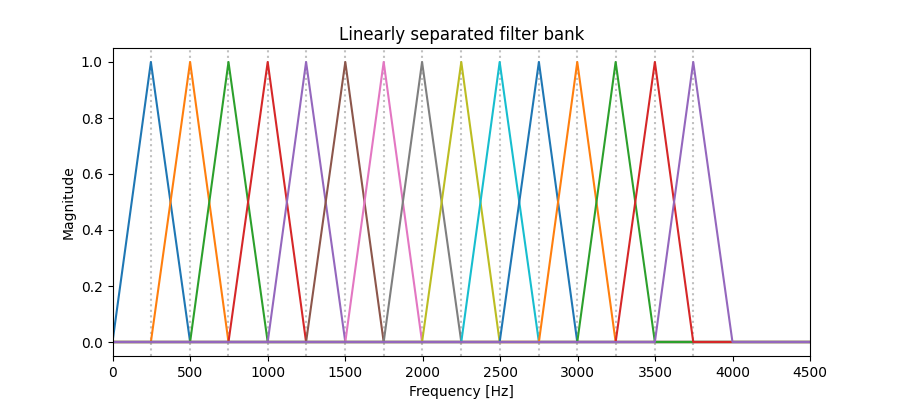

In [7]:
filter_type = 'triangular'
inverse_func = 'dct'
scale_type = 'linear'
sr = 11025
N = 2048
n_coefs = 15

# Definición del banco de filtros
bins_to, filbank = \
          get_filterbanks_plots(N=N, samplerate=sr, freq_lim=4000, n_coefs=n_coefs,
                                scale_type=scale_type, filter_type=filter_type,
                                norm_filters=False, plot_filterbank=False)

%matplotlib notebook
plt.figure(figsize=(9,4))

# Definición del vector de frecuencias
f_plot = np.arange(N) * sr / N
for num, filt in enumerate(filbank):
    plt.plot(f_plot, filt, zorder=1)

for i in bins_to[1:-1]: 
    plt.axvline(i * sr / N, c='silver', linestyle=':', zorder=0)
    
plt.xlim([0, 4500])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Linearly separated filter bank')
plt.savefig('Images/LFCC_filterbank_ENG.pdf', transparent=True)
plt.show()

<IPython.core.display.Javascript object>


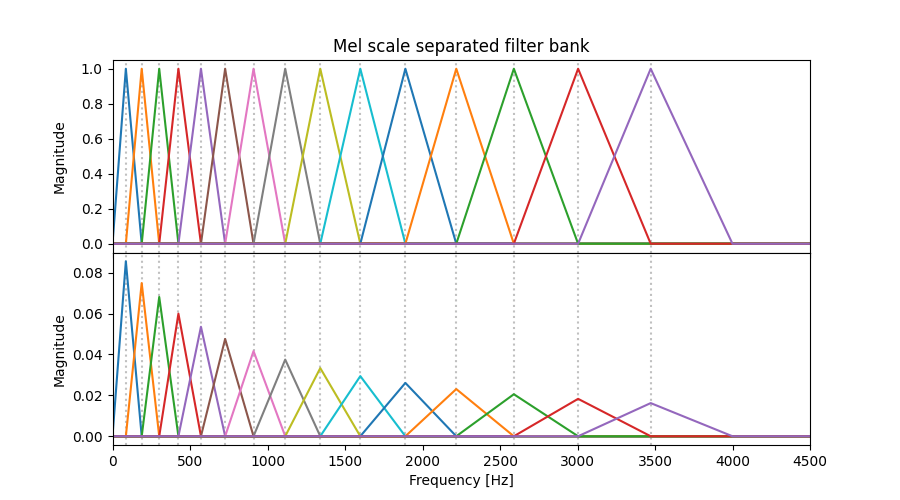

In [8]:
filter_type = 'triangular'
inverse_func = 'dct'
scale_type = 'mel'
sr = 11025
N = 2048
n_coefs = 15

# Definición del banco de filtros
bins_to, filbank = \
          get_filterbanks_plots(N=N, samplerate=sr, freq_lim=4000, n_coefs=n_coefs,
                                scale_type=scale_type, filter_type=filter_type,
                                norm_filters=False, plot_filterbank=False)

bins_to, filbank_norm = \
          get_filterbanks_plots(N=N, samplerate=sr, freq_lim=4000, n_coefs=n_coefs,
                                scale_type=scale_type, filter_type=filter_type,
                                norm_filters=True, plot_filterbank=False)

%matplotlib notebook
fig, ax = plt.subplots(2,1,figsize=(9,5), sharex=True)

# Definición del vector de frecuencias
f_plot = np.arange(N) * sr / N
for num, filt in enumerate(filbank):
    ax[0].plot(f_plot, filt, zorder=1)

for i in bins_to[1:-1]: 
    ax[0].axvline(i * sr / N, c='silver', linestyle=':', zorder=0)


for num, filt in enumerate(filbank_norm):
    ax[1].plot(f_plot, filt, zorder=1)

for i in bins_to[1:-1]: 
    ax[1].axvline(i * sr / N, c='silver', linestyle=':', zorder=0)

plt.xlim([0, 4500])
plt.xlabel('Frequency [Hz]')
ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel('Magnitude')
ax[0].set_title('Mel scale separated filter bank')

# Ajustando las etiquetas del eje
fig.align_ylabels(ax[:])
# Quitando el espacio entre gráficos
fig.subplots_adjust(wspace=0.1, hspace=0)

plt.savefig('Images/MFCC_filterbank_ENG.pdf', transparent=True)
plt.show()

In [83]:
bins_to

array([  0,  17,  36,  58,  82, 110, 141, 177, 217, 262, 313, 371])

# Escala de Mel

<IPython.core.display.Javascript object>


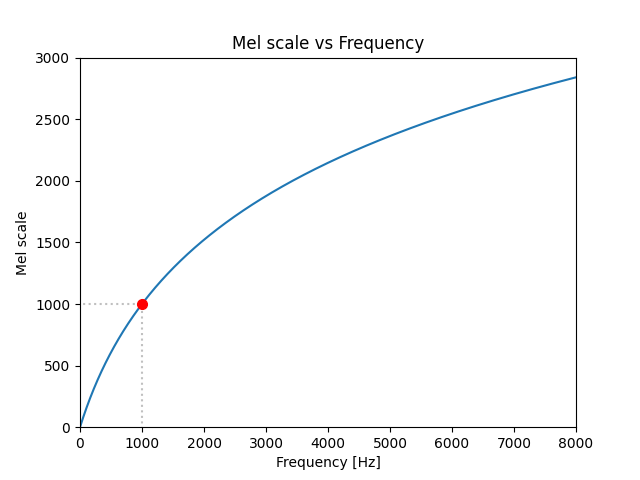

In [9]:
f = np.linspace(0,8000, 20000)
mel_scale = 2595 * np.log10(1 + f / 700)

%matplotlib notebook
plt.plot(f, mel_scale)
plt.plot([-300, 1000], [1000, 1000], color='silver', linestyle=':')
plt.plot([1000, 1000], [-100, 1000], color='silver', linestyle=':')
plt.plot(1000, 1000, linestyle='', marker='o', markersize=7, color='red')
plt.xlim([0, 8000])
plt.ylim([0, 3000])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mel scale')
plt.title('Mel scale vs Frequency')
plt.savefig('Images/Mel_scale_ENG.pdf', transparent=True)
plt.show()

# Energía por bandas

602.9296875
(26,)
2.4523809523809588
(513, 858)


<IPython.core.display.Javascript object>


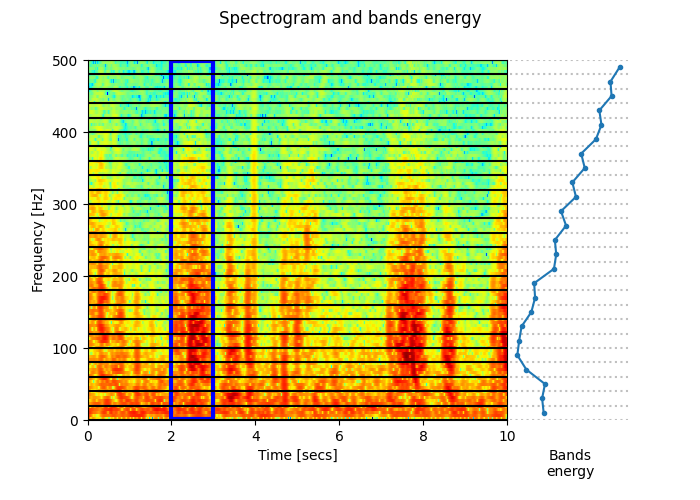

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [14]:
filename = f'un{db_folder}/106_2b1_Pl_mc_LittC2SE_44100.wav'
audio, samplerate = sf.read(filename)
N = 1024
nov = int(0.9 * N)

%matplotlib notebook
t, f, S = get_spectrogram(audio, samplerate, N=N, padding=0, repeat=0, 
                          noverlap=nov, window='hamming', whole=False)
print(f[140])
# Definición de los intervalos
f_intervals = np.arange(0, 501, 20)

print(f_intervals.shape)
print(t[105])
print(S.shape)

# Definición de la lista que almacenará los datos
energy_band = np.zeros(len(f_intervals) - 1)
energy_S = np.zeros((len(energy_band), len(t)))


for i in range(len(f_intervals) - 1):
    lower_lim = f_intervals[i]
    upper_lim = f_intervals[i + 1]
    
    # Definición de los índices de interés
    indexes = np.where((lower_lim <= f) & (f <= upper_lim))[0]
    
    # Definiendo el valor
    energy_S[i] = np.sum(abs(S[indexes,:]) ** 2, axis=0)


fig, ax = plt.subplots(1, 2, figsize=(7,5), gridspec_kw={'width_ratios':[3.5,1]})
# ax[0].pcolormesh(t, f, 20 * np.log10(abs(S)), cmap='jet')
ax[0].pcolormesh(t, f[:N//4], 20 * np.log10(abs(S))[:N//4], cmap='jet')
rect = patches.Rectangle((2, 1), width=1, height=498, linewidth=3, edgecolor='b', facecolor='none')
ax[0].add_patch(rect)
for i in f_intervals:
    ax[0].axhline(y=i, color='k')
# plt.colorbar()
ax[0].set_xlim([0,10])
ax[0].set_ylim([0,500])
ax[0].set_xlabel('Time [secs]')
ax[0].set_ylabel('Frequency [Hz]')

ax[1].plot(20 * np.log10(abs(energy_S[:,105])), 0.5 + np.arange(len(energy_S)), zorder=1, marker='.')
ax[1].invert_xaxis()
# ax[1].axis('off')
ax[1].get_xaxis().set_ticklabels([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_visible(False)
ax[1].set_xlabel('Bands\nenergy')
ax[1].set_xlim([-30, -150])
ax[1].set_ylim([0, len(f_intervals) - 1])
for i in range(len(f_intervals)):
    ax[1].axhline(y=i, color='silver', zorder=0, linestyle=':')
    

ax[1].spines["bottom"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["right"].set_visible(False)
    
# s1 = ax[1].pcolormesh(t, np.arange(len(f_intervals)), 20 * np.log10(abs(energy_S)), cmap='jet')
# ax[1].set_xlim([0,10])
# plt.colorbar(s1)

fig.align_xlabels(ax[:])
fig.subplots_adjust(hspace=0.1, wspace=0.01, bottom=0.16)

plt.suptitle('Spectrogram and bands energy')
plt.savefig('Images/Spectrogram_band_energy_ENG.png', transparent=True)
plt.show()

# Definición de las etiquetas

In [15]:
from respiratory_sound_classification.respiratory_sound_management import get_label_filename

In [16]:
# Dirección de la base de datos
db_original = 'C:/Users/Chris/Desktop/Scripts_Magister/Respiratory_Sound_Database/audio_and_txt_files'

_filenames_TC = [i[:-4] for i in os.listdir(db_original) if i.endswith('.wav') and 'Tc' in i]
_filenames_notTC = [i[:-4] for i in os.listdir(db_original) if i.endswith('.wav') and not 'Tc' in i]

print('Sonidos en el pecho:   ', len(_filenames_notTC))
print('Sonidos en la tráquea: ', len(_filenames_TC))

Sonidos en el pecho:    790
Sonidos en la tráquea:  130


In [17]:
# Dirección de la base de datos
db_folder = 'unpreprocessed_signals'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

<IPython.core.display.Javascript object>


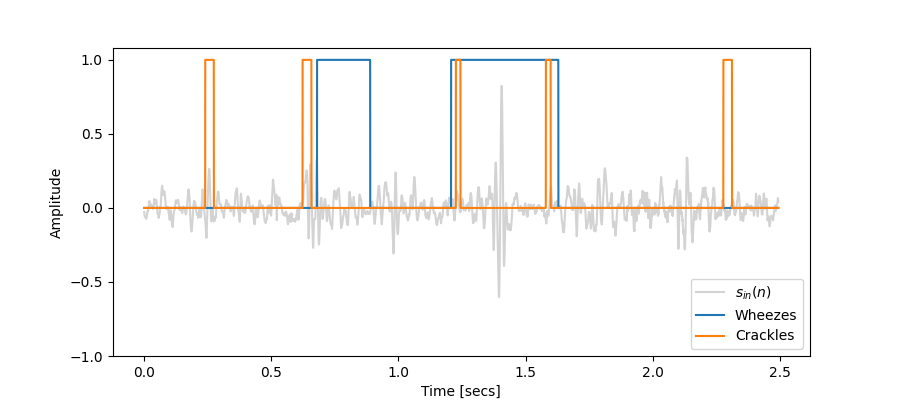

In [18]:
# Parámetros
index_to = 95
#35,61
# Definición del nombre del archivo de audio a revisar
filename_to = filenames[index_to]

# Dirección del archivo de audio
filename_audio = f'{db_folder}/{filename_to}'

# Lectura del audio
try:
    samplerate, audio = wavfile.read(f'{filename_audio}.wav')
except:
    audio, samplerate = sf.read(f'{filename_audio}.wav')

audio = audio / max(abs(audio))
    
# Obtención de las etiquetas
filename_label = '_'.join(filename_to.split('_')[:-1])
Y_wheeze, Y_crackl = \
        get_label_filename(filename_label, samplerate, length_desired=len(audio))

%matplotlib notebook
lower_lim = 29000
upper_lim = 40000
# t = np.arange(len(audio)) / samplerate
t = np.arange(abs(upper_lim - lower_lim))  / samplerate

plt.figure(figsize=(9,4))
audio_plot = (audio - min(audio)) / (max(audio) - min(audio))
plt.plot(t, audio[lower_lim:upper_lim], color='lightgrey', label=r'$s_{in}(n)$')
plt.plot(t, Y_wheeze[lower_lim:upper_lim], color='C0', label='Wheezes')
plt.plot(t, Y_crackl[lower_lim:upper_lim], color='C1', label='Crackles')
plt.xlabel('Time [secs]')
plt.ylabel('Amplitude')
plt.yticks([-1, -0.5, 0, 0.5, 1])
# plt.yticks([0, 0.5, 1])
plt.legend(loc='lower right')

plt.savefig('Images/Classification_labels_ENG.pdf', transparent=True)
plt.show()

# Ejemplo de features (LFCC, MFCC, energía por bandas)

In [24]:
db_folder = 'preprocessed_signals'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

# Parámetros de caracaterísticas (no modificar)
N = 1024
noverlap = int(0.9 * N)
spec_params = {'N': N, 'noverlap': noverlap, 'window': 'hann', 
               'padding': 0, 'repeat': 0}
mfcc_params = {'n_mfcc': 50, 'n_filters': 50, 'spec_params': spec_params,
               'freq_lim': 2000, 'norm_filters': True, 'power': 2}
lfcc_params = {'n_mfcc': 50, 'n_filters': 50, 'spec_params': spec_params,
               'freq_lim': 2000, 'norm_filters': True, 'power': 2}
energy_params = {'spec_params': spec_params, 'fmin': 0, 'fmax': 1000, 
                 'fband': 20}

In [67]:
def get_ML_data(filenames, spec_params, mfcc_params=None, 
                lfcc_params=None, energy_params=None):
    # Definición de la lista donde se acumulará la información
    X_data = list()
    
    # Definición de los arrays donde se acumularán las etiquetas
    Y_wheeze = list()
    Y_crackl = list()
    
    # Nombre del archivo .wav a utilizar
    for num, filename in enumerate(filenames):
        print(f'Iteración {num + 1}: {filename}')
        print(f'--------------------------')
        
        # Cargando el archivo
        try:
            samplerate, resp_signal = wavfile.read(f'{filename}.wav')
        except:
            resp_signal, samplerate = sf.read(f'{filename}.wav')
        
        print(f'Samplerate = {samplerate}, largo = {resp_signal.shape}')
        
        # Normalizando
        resp_signal = resp_signal / max(abs(resp_signal))
        
        
        # Obtener el tiempo y la dimensión de las características
        t, _, _ = get_spectrogram(resp_signal, samplerate, 
                                  N=spec_params['N'], 
                                  padding=spec_params['padding'], 
                                  repeat=spec_params['repeat'], 
                                  noverlap=spec_params['noverlap'], 
                                  window=spec_params['window'], 
                                  whole=False)
        
        # Obteniendo la información de los segmentos de este archivo de 
        # audio
        name_lab = '_'.join(filename.split('/')[-1].split('_')[:-1])
        Y_wheeze_i, Y_crackl_i = \
                get_label_filename_ML(filename=name_lab, time_array=t)       
        
        
        # Definición de la matriz de características
        feat_mat = np.zeros((0, len(t)))     
        
        
        ### Calculando las características ###

        # Cálculo del MFCC
        if mfcc_params is not None:
            # Calculando la característica
            mfcc_features = \
                get_cepstral_coefficients(resp_signal, samplerate, 
                                          spectrogram_params=mfcc_params['spec_params'],
                                          freq_lim=mfcc_params['freq_lim'], 
                                          n_filters=mfcc_params['n_filters'], 
                                          n_coefs=mfcc_params['n_mfcc'], 
                                          scale_type='mel', 
                                          filter_type='triangular', inverse_func='dct', 
                                          norm_filters=mfcc_params['norm_filters'], 
                                          plot_filterbank=False, 
                                          power=mfcc_params['power'])
            
            # Agregando
            feat_mat = np.concatenate((feat_mat, mfcc_features), axis=0)
            

        # Cálculo del LFCC
        if lfcc_params is not None:
            # Calculando la característica
            lfcc_features = \
                get_cepstral_coefficients(resp_signal, samplerate, 
                                          spectrogram_params=lfcc_params['spec_params'],
                                          freq_lim=lfcc_params['freq_lim'], 
                                          n_filters=lfcc_params['n_filters'], 
                                          n_coefs=lfcc_params['n_mfcc'], 
                                          scale_type='linear', 
                                          filter_type='triangular', inverse_func='dct', 
                                          norm_filters=lfcc_params['norm_filters'], 
                                          plot_filterbank=False, 
                                          power=lfcc_params['power'])
            
            # Agregando
            feat_mat = np.concatenate((feat_mat, lfcc_features), axis=0)

        
        # Cálculo de la energía por bandas
        if energy_params is not None:
            # Calculando la característica
            energy_S = \
                get_energy_bands(resp_signal, samplerate,
                                 spectrogram_params=energy_params['spec_params'],
                                 fmin=energy_params['fmin'], 
                                 fmax=energy_params['fmax'], 
                                 fband=energy_params['fband'])
            
            # Agregando
            feat_mat = np.concatenate((feat_mat, energy_S), axis=0)
            
        
        # Agregando la información a cada arreglo
        for i in range(feat_mat.shape[1]):
            X_data.append(feat_mat[:,i])
            Y_wheeze.append(Y_wheeze_i[i])
            Y_crackl.append(Y_crackl_i[i])

        print(f'Dimensión datos: {feat_mat.shape}')
        # print(Y_wheeze_i.shape)
        # print(Y_crackl_i.shape)

    
    return np.array(X_data), np.array(Y_wheeze), np.array(Y_crackl)


def get_filterbanks(N, samplerate, freq_lim, n_filters, norm_exp=1,
                    scale_type='mel', filter_type='triangular',
                    norm_filters=True, plot_filterbank=False):
    '''Función que permite obtener un banco de filtros linealmente
    espaciados o espaciados en frecuencia de mel para calcular
    coeficientes cepstrales.
    
    Parameters
    ----------
    N : ndarray
        Largo de la señal.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_filters : int
        Cantidad de filtros a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''
    def _freq_to_bin(f):
        # Definición del bin correspondiente en la definición
        # del intervalo de cálculo. Se usa (N - 1) ya que los bins
        # se definen entre 0 y (N - 1) (largo N)
        return np.rint(f / samplerate * (N - 1)).astype(int)
    
    
    def _triangular_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i] + 1] = \
                np.linspace(0, 1, abs(bins_points[i] - bins_points[i - 1] + 1))
            
            # Tramo descendente del filtro triangular
            filter_bank[i - 1][bins_points[i]:bins_points[i + 1] + 1] = \
                np.linspace(1, 0, abs(bins_points[i + 1] - bins_points[i] + 1))
            
        return filter_bank
    
    
    def _hanning_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = \
                np.hanning(abs(bins_points[i + 1] - bins_points[i - 1] + 1))
        
        return filter_bank
    
    
    def _squared_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = 1
        
        return filter_bank
    
    
    def _norm_filterbank(filter_bank):
        # Definición del banco de filtros de salida
        filter_bank_out = np.zeros((n_filters, N))
        
        # Normalizar los filtros a energía 1
        for i in range(n_filters):
            filter_bank_out[i] = filter_bank[i] / \
                                 sum(filter_bank[i] ** norm_exp)
            
        return filter_bank_out
    
    
    # Definición de los bines en base a las frecuencias de cada filtro
    if scale_type == 'linear':
        # Definición de las "n_filters" frecuencias equiespaciadas entre
        # 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya que se 
        # necesitan para definir los límites de los filtros.
        freqs = np.arange(0, (n_filters + 1) + 1) * freq_lim / (n_filters + 1)
    
    
    elif scale_type == 'mel':
        # Definición del límite en frecuencias de mel (para no pasarse del
        # freq_lim al devolverse)
        mel_freq_lim = 2595 * np.log10(1 + freq_lim / 700)
        
        # Definición de las "n_filters" frecuencias espaciadas en escala mel 
        # entre 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya 
        # que se necesitan para definir los límites de los filtros.
        mel_freqs = np.arange(0, (n_filters + 1) + 1) * mel_freq_lim / (n_filters + 1)
        
        # Transformando de intervalos equi espaciados usando la escala
        # de mel. Es necesario hacer la transformación inversa ya que
        # en este caso se dice que lo equi espaciado viene de mel
        freqs = 700 * (10 ** (mel_freqs / 2595) - 1)
    
    else:
        raise Exception('Opción de tipo de coeficiente cepstral no válido.')
    
    
    # Transformando a bins
    bins_to = _freq_to_bin(freqs)
    
    
    # Obtención del banco de filtros
    if filter_type == 'triangular':
        filter_bank = _triangular_filter(bins_to)
        
    if filter_type == 'hanning':
        filter_bank = _hanning_filter(bins_to)
    
    elif filter_type == 'squared':
        filter_bank = _squared_filter(bins_to)
    
    # Normalizar por la energía de la señal
    if norm_filters:
        filter_bank = _norm_filterbank(filter_bank)
    
    
    # Gráfico del banco de filtros
    if plot_filterbank:
        plt.figure()
        
        # Definición del vector de frecuencias
        # f_plot = np.arange(N) * samplerate / N
        
        for i in range(n_filters):
            plt.plot(filter_bank[i])
            # plt.plot(f_plot, filter_bank[i])

        for i in bins_to:
            # plt.axvline(i * samplerate / N, c='silver', linestyle=':')
            plt.axvline(i, c='silver', linestyle=':')
            
        # plt.xlim([0, freq_lim])
        plt.xlim([0, bins_to[-1]])
        plt.show()
    
    
    return filter_bank


def get_cepstral_coefficients(signal_in, samplerate, spectrogram_params,
                              freq_lim, n_filters, n_coefs, scale_type='mel', 
                              filter_type='triangular', inverse_func='dct', 
                              norm_filters=True, plot_filterbank=False, 
                              power=2):
    '''Función que permite obtener los coeficientes cepstrales a partir de 
    un banco de filtros.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''    
    # Definición de la cantidad de puntos a considerar
    filter_bank = get_filterbanks(spectrogram_params['N'], samplerate, 
                                  freq_lim=freq_lim, n_filters=n_filters, 
                                  scale_type=scale_type, 
                                  filter_type=filter_type,
                                  norm_filters=norm_filters, 
                                  plot_filterbank=plot_filterbank)
    
    # Obtener el espectrograma de la señal
    _, _, S = get_spectrogram(signal_in, samplerate, N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=True)
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(S) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    energy_coefs = np.dot(filter_bank, energy_spectrum)
    
    # Aplicando el logaritmo
    energy_coefs = np.log(energy_coefs + 1e-10)
    
    # Calculando los coeficientes cepstrales
    if inverse_func == 'dct':
        cepstral_coefs = fftpack.dct(energy_coefs, norm='ortho', axis=0)
    elif inverse_func == 'idft':
        cepstral_coefs = np.fft.ifft(energy_coefs, axis=-1).real
    else:
        raise Exception('Opción de tipo de función inversa no válida.')
    
    
    return cepstral_coefs[:n_coefs]


def get_energy_bands(signal_in, samplerate, spectrogram_params, 
                     fmin=0, fmax=1000, fband=20, power=2):
    '''Función que permite definir un espectrograma en bandas de 
    energía.
    
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    spectrogram_params : dict
        Parámetros del espectrograma.
    fmin : float, optional
        Frecuencia mínima a considerar en el intervalo de interés.
        Por defecto es 0.
    fmax : float, optional
        Frecuencia máxima a considerar en el intervalo de interés.
        Este valor no puede mayor a samplerate / 2. Por defecto 
        es 1000.
    fband : float, optional
        Ancho de cada banda de frecuencia entre fmin y fmax. Por 
        defecto es 20.
    power : float, optional
        Exponente con el que se calcula la energía.
    
    Returns
    -------
    energy_S : ndarray
        Bandas de energía a través del tiempo (formato 
        espectrograma) con dimensión (#bandas x #bins de tiempo 
        del espectrograma).     
    '''
    # Obtener el espectrograma
    t, f, S = get_spectrogram(signal_in, samplerate, 
                              N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=False)
    
    # Definición de los intervalos
    f_intervals = np.arange(fmin, fmax, fband)

    # Definición de la lista que almacenará los datos
    energy_band = np.zeros(len(f_intervals) - 1)
    energy_S = np.zeros((len(energy_band), len(t)))

    for i in range(len(f_intervals) - 1):
        lower_lim = f_intervals[i]
        upper_lim = f_intervals[i + 1]

        # Definición de los índices de interés
        indexes = np.where((lower_lim <= f) & (f <= upper_lim))[0]

        # Definiendo el valor
        energy_S[i] = np.sum(abs(S[indexes,:]) ** power, axis=0)
    
    return energy_S


# LFCC

Iteración 1: unpreprocessed_signals/107_3p2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Dimensión datos: (50, 858)


<IPython.core.display.Javascript object>


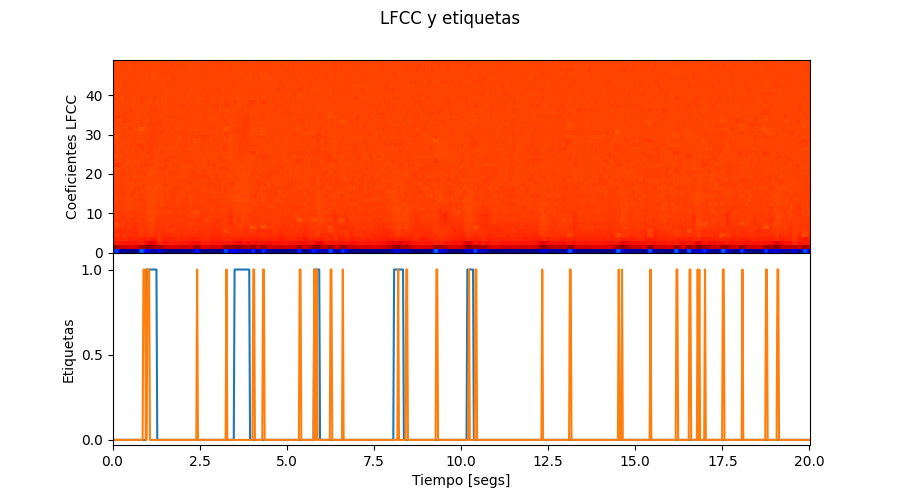

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [64]:
# Obtener el tiempo y la dimensión de las características
# Parámetros
index_to = 35
#35,61,95
# Definición del nombre del archivo de audio a revisar
filename_to = filenames[index_to]
filename_audio = f'{db_folder}/{filename_to}'

audio, sr = sf.read(f'{filename_audio}.wav')
t, _, _ = get_spectrogram(audio, sr, N=spec_params['N'], 
                          padding=spec_params['padding'], 
                          repeat=spec_params['repeat'], 
                          noverlap=spec_params['noverlap'], 
                          window=spec_params['window'], 
                          whole=False)

%matplotlib notebook
LFCC, Y_wheeze, Y_crackl = \
    get_ML_data([filename_audio], spec_params=spec_params, mfcc_params=None, 
                lfcc_params=lfcc_params, energy_params=None)



fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
ax[0].pcolormesh(t, np.arange(LFCC.shape[1]), LFCC.T, cmap='jet')
ax[0].set_ylabel('Coeficientes LFCC')

ax[1].plot(t, Y_wheeze)
ax[1].plot(t, Y_crackl)
ax[1].set_xlim([t[0], t[-1]])
ax[1].set_yticks([0, 0.5, 1])
ax[1].set_ylim([-0.03, 1.1])
ax[1].set_ylabel('Etiquetas')
ax[1].set_xlabel('Tiempo [segs]')

fig.align_xlabels(ax[:])
fig.subplots_adjust(hspace=0, wspace=0.01)

fig.suptitle('LFCC y etiquetas')
plt.savefig('Images/LFCC_example.pdf', transparent=True)
plt.show()

# MFCC

Iteración 1: unpreprocessed_signals/107_3p2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Dimensión datos: (50, 858)


<IPython.core.display.Javascript object>


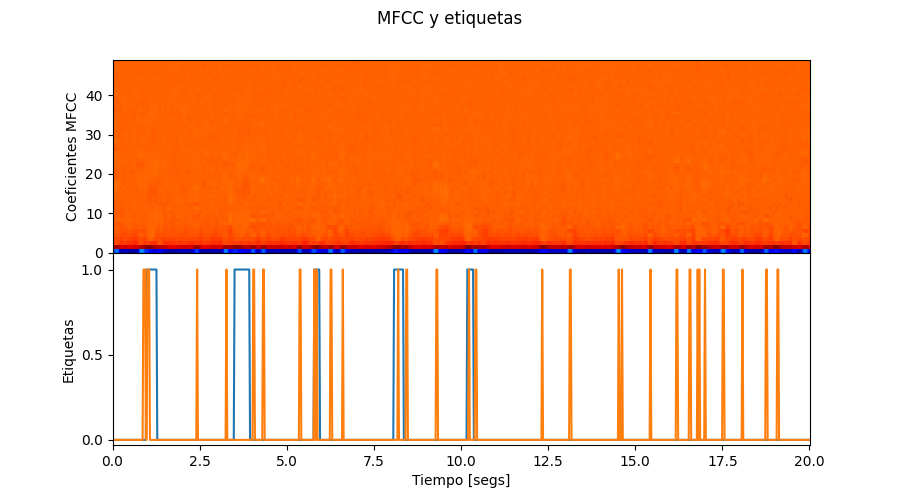

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [65]:
# Obtener el tiempo y la dimensión de las características
# Parámetros
index_to = 35
#35,61,95
# Definición del nombre del archivo de audio a revisar
filename_to = filenames[index_to]
filename_audio = f'{db_folder}/{filename_to}'

audio, sr = sf.read(f'{filename_audio}.wav')
t, _, _ = get_spectrogram(audio, sr, N=spec_params['N'], 
                          padding=spec_params['padding'], 
                          repeat=spec_params['repeat'], 
                          noverlap=spec_params['noverlap'], 
                          window=spec_params['window'], 
                          whole=False)

%matplotlib notebook
MFCC, Y_wheeze, Y_crackl = \
    get_ML_data([filename_audio], spec_params=spec_params, mfcc_params=mfcc_params, 
                lfcc_params=None, energy_params=None)

fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
ax[0].pcolormesh(t, np.arange(MFCC.shape[1]), MFCC.T, cmap='jet')
ax[0].set_ylabel('Coeficientes MFCC')

ax[1].plot(t, Y_wheeze)
ax[1].plot(t, Y_crackl)
ax[1].set_xlim([t[0], t[-1]])
ax[1].set_yticks([0, 0.5, 1])
ax[1].set_ylim([-0.03, 1.1])
ax[1].set_ylabel('Etiquetas')
ax[1].set_xlabel('Tiempo [segs]')

fig.align_xlabels(ax[:])
fig.subplots_adjust(hspace=0, wspace=0.01)

fig.suptitle('MFCC y etiquetas')
plt.savefig('Images/MFCC_example.pdf', transparent=True)
plt.show()

# Energía por bandas

Iteración 1: unpreprocessed_signals/107_3p2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Dimensión datos: (49, 858)


<IPython.core.display.Javascript object>


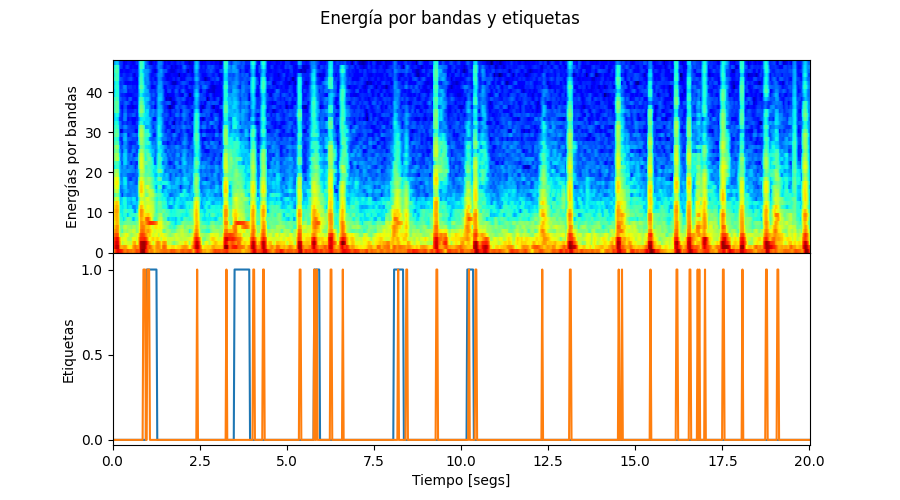

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [69]:
# Obtener el tiempo y la dimensión de las características
# Parámetros
index_to = 35
#35,61,95
# Definición del nombre del archivo de audio a revisar
filename_to = filenames[index_to]
filename_audio = f'{db_folder}/{filename_to}'

audio, sr = sf.read(f'{filename_audio}.wav')
t, _, _ = get_spectrogram(audio, sr, N=spec_params['N'], 
                          padding=spec_params['padding'], 
                          repeat=spec_params['repeat'], 
                          noverlap=spec_params['noverlap'], 
                          window=spec_params['window'], 
                          whole=False)

%matplotlib notebook
MFCC, Y_wheeze, Y_crackl = \
    get_ML_data([filename_audio], spec_params=spec_params, mfcc_params=None, 
                lfcc_params=None, energy_params=energy_params)

fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
ax[0].pcolormesh(t, np.arange(MFCC.shape[1]), 20 * np.log10(MFCC.T), cmap='jet')
ax[0].set_ylabel('Energías por bandas')

ax[1].plot(t, Y_wheeze)
ax[1].plot(t, Y_crackl)
ax[1].set_xlim([t[0], t[-1]])
ax[1].set_yticks([0, 0.5, 1])
ax[1].set_ylim([-0.03, 1.1])
ax[1].set_ylabel('Etiquetas')
ax[1].set_xlabel('Tiempo [segs]')

fig.align_xlabels(ax[:])
fig.subplots_adjust(hspace=0, wspace=0.01)

fig.suptitle('Energía por bandas y etiquetas')
plt.savefig('Images/Energy_example.pdf', transparent=True)
plt.show()

# Señales para redes

In [ ]:
db_folder = 'preprocessed_signals'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

<IPython.core.display.Javascript object>


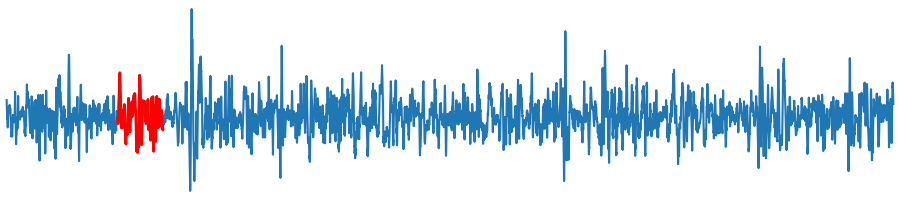

<IPython.core.display.Javascript object>


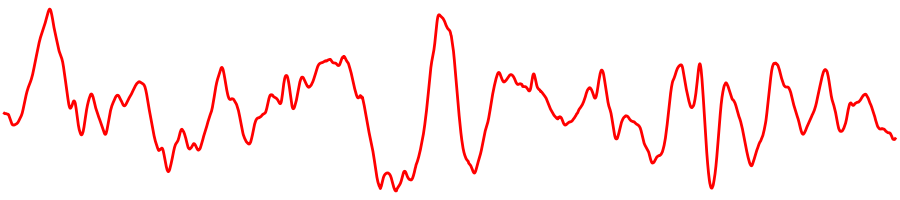

In [47]:
# Obtener el tiempo y la dimensión de las características
# Parámetros
index_to = 95
#35,61,95
# Definición del nombre del archivo de audio a revisar
filename_to = filenames[index_to]
filename_audio = f'{db_folder}/{filename_to}'

# Cargando el archivo
audio, sr = sf.read(f'{filename_audio}.wav')

# Parámetros
N = 2048
beg_seg = 10000
end_seg = 50000

beg_wind = 5000

%matplotlib notebook
audio_seg = audio[beg_seg:end_seg]

fig = plt.figure(figsize=(9,2))
plt.plot(audio_seg)
plt.plot(np.arange(beg_wind,beg_wind+N), audio_seg[beg_wind:beg_wind+N], 
         color='r', linewidth=2)
plt.xlim([-300, 40300])
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.axis('off')
fig.savefig('Images/signal_in_cnn.svg', transparent=True)
plt.show()

fig = plt.figure(figsize=(9,2))
plt.plot(np.arange(beg_wind,beg_wind+N), audio_seg[beg_wind:beg_wind+N], 
         color='r', linewidth=2)
plt.xlim([beg_wind-10, beg_wind+N+ 10])
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.axis('off')
fig.savefig('Images/signal_in_cnn_zoom.svg', transparent=True)
plt.show()